# Reto Predicción de Contingencias Ambientales en el Área Metropolitana de la Ciudad de Monterrey
------
##Presentado a: Prof. Raúl Valente Ramirez Velarde
##Presentado por: Sebastián Torres Franco

In [ ]:
#**************************************** Conexión GDrive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#**************************************** Instalación de librerías
#************** Pyspark
!pip install pyspark py4j
from pyspark.sql import SparkSession

#************* Machine Learning
from pyspark.ml.feature import VectorAssembler # Vectorización variables de entrada
from pyspark.ml.regression import LinearRegression # Modelo lineal
from pyspark.ml.regression import RandomForestRegressor # Moldelo RFR
from pyspark.ml.regression import GBTRegressor # Modelo GBT
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

#************ Scoring y evaluación
from pyspark.ml.evaluation import RegressionEvaluator

#************ Gáficas
import matplotlib.pyplot as plt
import plotly.express as px
from plotnine import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

#************ Otros procesamientos
import pandas as pd
import numpy as np
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import exp,log,col,round

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=733ccbdb813d41879829baccba13df89862e5971d9cac572d7e9fcb84e9fb988
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
#**************************************** Se crea la sesión de spark
spark = SparkSession.builder.appName("Reto_pyspark").getOrCreate()  #Método actual para crear la sesión

#Lectura y carga de archivo

* Tras examinar la variables del dataframe, se encuentra la siguiente información redundante: "Date","Month","Day".Se puede observar que el campo date, ya está representado por las variables Month, y Day. Teniendo en cuenta que toda la data es del 2015, el campo es redundante.

* También se encuentra que los campos "DayWeek" y "Weekday" son redundantes

* Por otro lado, se modifica el nombre de la variable PM2.5 a PM2_5 para evitar problemas de sintaxis

* Se examina el dataframe por valores nulos, y no se encuentra ningún vacío en la data. Todos los campos tienen información.

In [ ]:
from pyspark.sql.functions import coalesce, to_date, lit,concat_ws
#**************************************** Exploración de información en el dataframe
#************ Lectura de archivo
data_raw=spark.read.csv("/content/gdrive/MyDrive/Colab Notebooks/ArchivosCarga/PySpark/MonterreyPollutionData2.csv",inferSchema=True,header=True)


data_set=data_raw.alias("data_set") #Se crea una copia de trabajo para el código
#************ Exploración de campos y variables
data_set.show(5) #Impresión de una muestra de la tabla
data_set.printSchema() #Tipos de variable
for var in data_set.columns: #Verificac
    print(f"\n Campos Nulos variable {var} ", data_set.filter(f" `{var}` IS NULL ").count())



+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|     Date|Month|Day|DayWeek|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2.5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|01-ene-15|    1|  1|    jue|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|01-ene-15|    1|  1|    jue|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|01-ene-15|    1|  1|    jue|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|01-ene-15|    1|  1|    jue|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|01-ene-15|    1|  1|    jue|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+---

In [ ]:
#**************************************** Limpieza de datos
#************ Se eliminan las variables con información redundante
data_set=data_set.drop("Date","DayWeek")

#************ Se modifican nombres de variables problemáticos
#Para evitar problemas con la variable PM2.5 se renombra como PM2_5

data_set=data_set.withColumnRenamed("PM2.5","PM2_5")
data_set.show(5) #Impresión con muestra del nuevo dataframe


+-----+---+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|Month|Day|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2_5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+-----+---+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|    1|  1|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|    1|  1|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|    1|  1|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|    1|  1|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|    1|  1|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
+-----+---+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
only showing top 5 rows



# Exploración de datos

A continuación se presenta un estudio de la estadística descriptiva, análisis de gráficos estadísticos, y estudio de correlación sobre las variables. Las conclusiones de la sección son:

* Las varias de las variables presentan outlieres, sin embargo, ya que no se conoce la importancia de tenerlos o no en cuenta para el estudio se mantienen dentro de los análisis.

* Se encuentra que varias variables presentan sesgos, incluyendo las variables de salida O3 y PM2.5. Esto puede ser mejorado de cara a los modelos de machine learning con una transformada log(x+1)


##Estadística descriptiva

Se encuentra qué, puntualmente las variables de salida "O3", y "PM2_5", se encuentra que los valores máximos están a más de 4 desviaciones estándar del valor medio. Esto permite pensar que las distribuciones tendrán sesgo derecho.

In [ ]:
data_stats=data_set.describe() #Se genera dataframe con información de estadística descriptiva

for column in data_stats.columns: #Se redondean las estadísticas a dos decimales
    if column != "summary":
       data_stats=data_stats.withColumn(column, round(col(column),2))

data_stats.show() #Impresión de resultados

+-------+------+------+-------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|summary| Month|   Day|WeekDay|  Hour|    CO|    NO|   NO2|   NOX|    O3|  PM10| PM2_5|   PRS| RAINF|    RH|    SR|  TOUT|   WSR|   WDV|
+-------+------+------+-------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|  count|3859.0|3859.0| 3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|3859.0|
|   mean|  4.82| 15.76|   4.08| 12.04|   1.8|  13.5| 17.54| 30.97| 22.66| 86.05| 27.68|719.63|   0.0| 71.05|  0.18| 22.02|  7.33|127.52|
| stddev|  2.84|  9.16|   1.97|  6.87|  0.87| 26.86|  13.3| 36.09| 16.51| 49.01| 16.85|   3.7|  0.04| 18.33|  0.26|  7.55|  3.83| 96.52|
|    min|   1.0|   1.0|    1.0|   0.0|  0.29|   2.3|   0.4|   3.1|   2.0|   8.0|   5.0| 708.4|   0.0|  12.0|   0.0|  3.03|   0.9|   0.0|
|    max|  11.0|  31.0|    7.0|  23.0|  8

## Exploración Gráfica

Se presenta el boxplot e histograma para cada variable del data set. Aprovechando que no es un set tan extenso se grafica teniendo en cuenta todos los registros, y no únicamente un sample.

* De los boxplot se encuentra que las varias de las variables presentan outlieres, sin embargo, ya que no se conoce la importancia de tenerlos o no en cuenta para el estudio se mantienen dentro de los análisis.

* De los histogramas se encuentra que varias variables presentan sesgos. Esto puede ser mejorado de cara a los modelos de machine learning con una transformada log(x+1)

/usr/local/lib/python3.10/dist-packages/plotnine/themes/themeable.py:1902: FutureWarning:

You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.



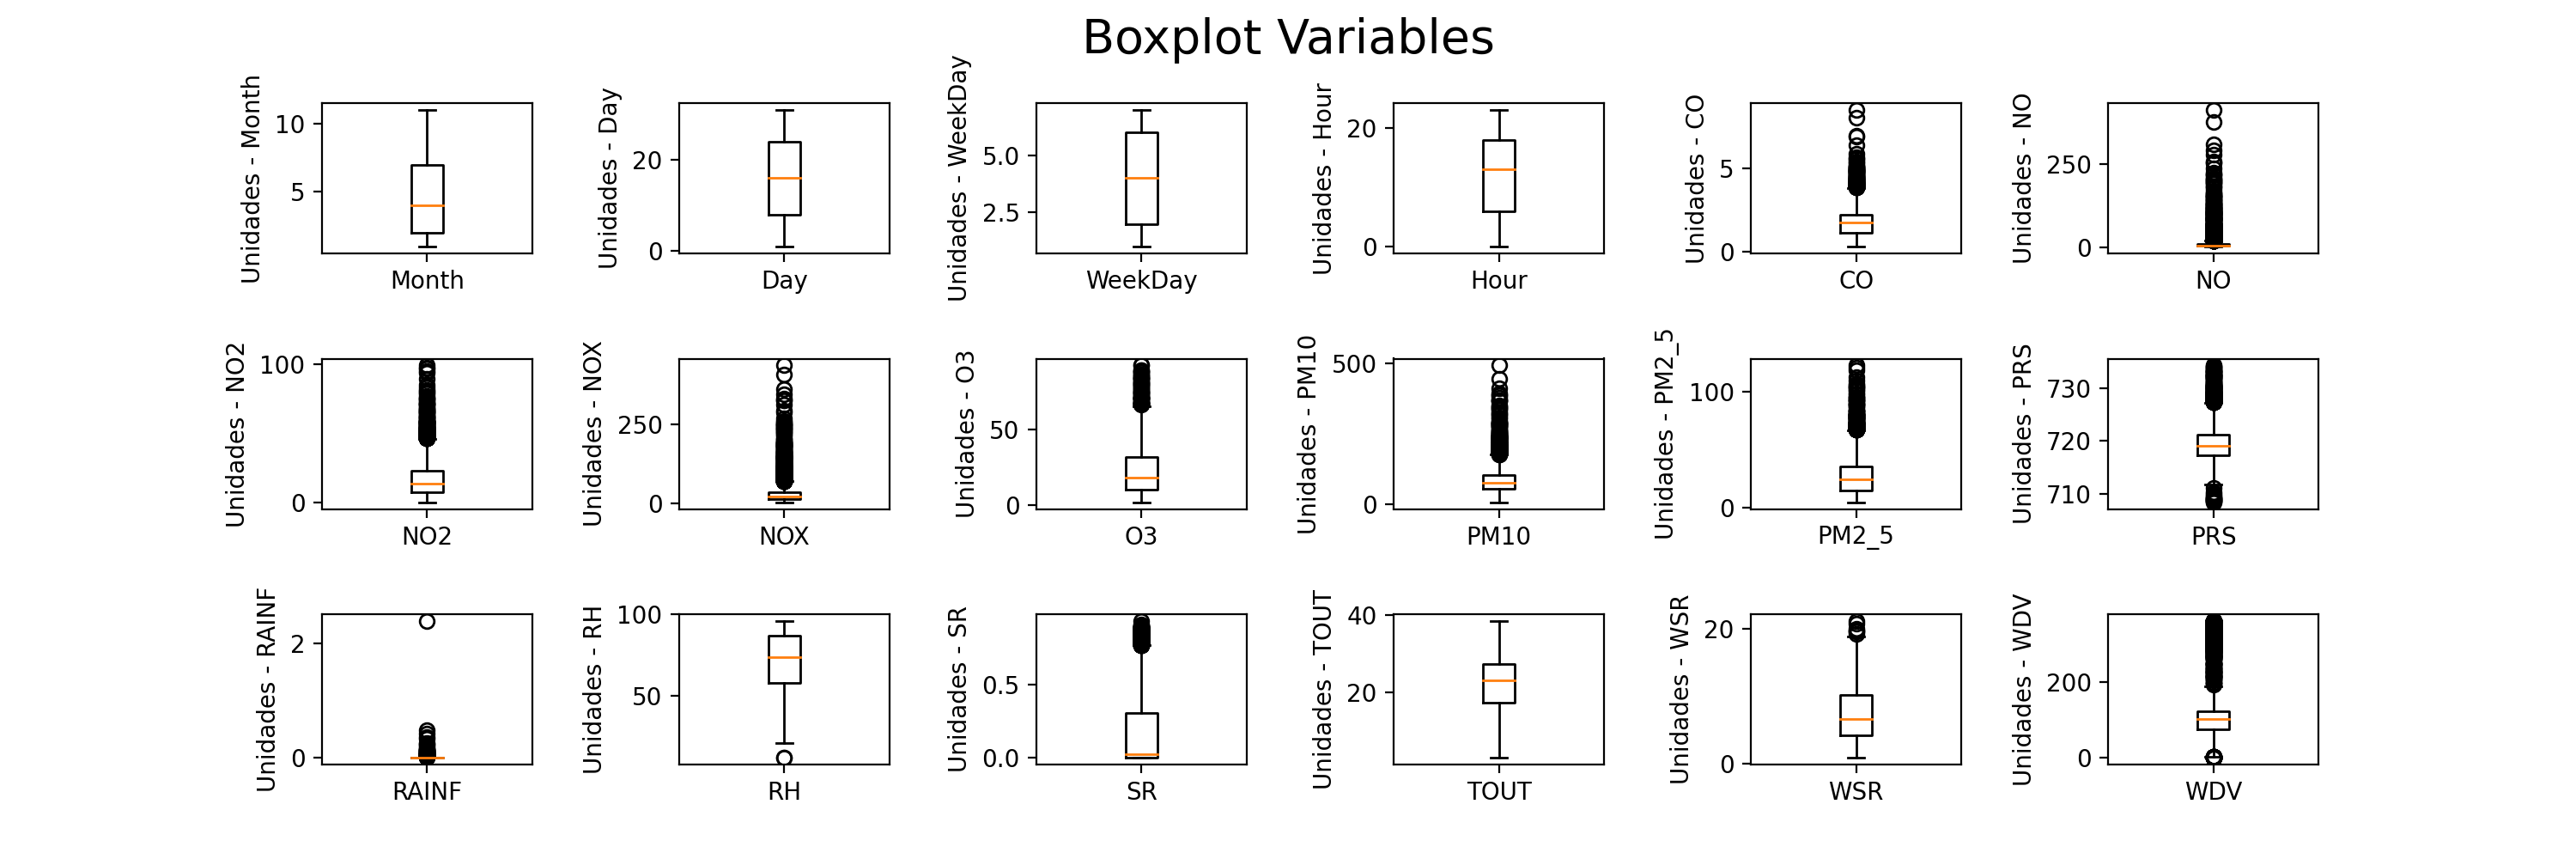

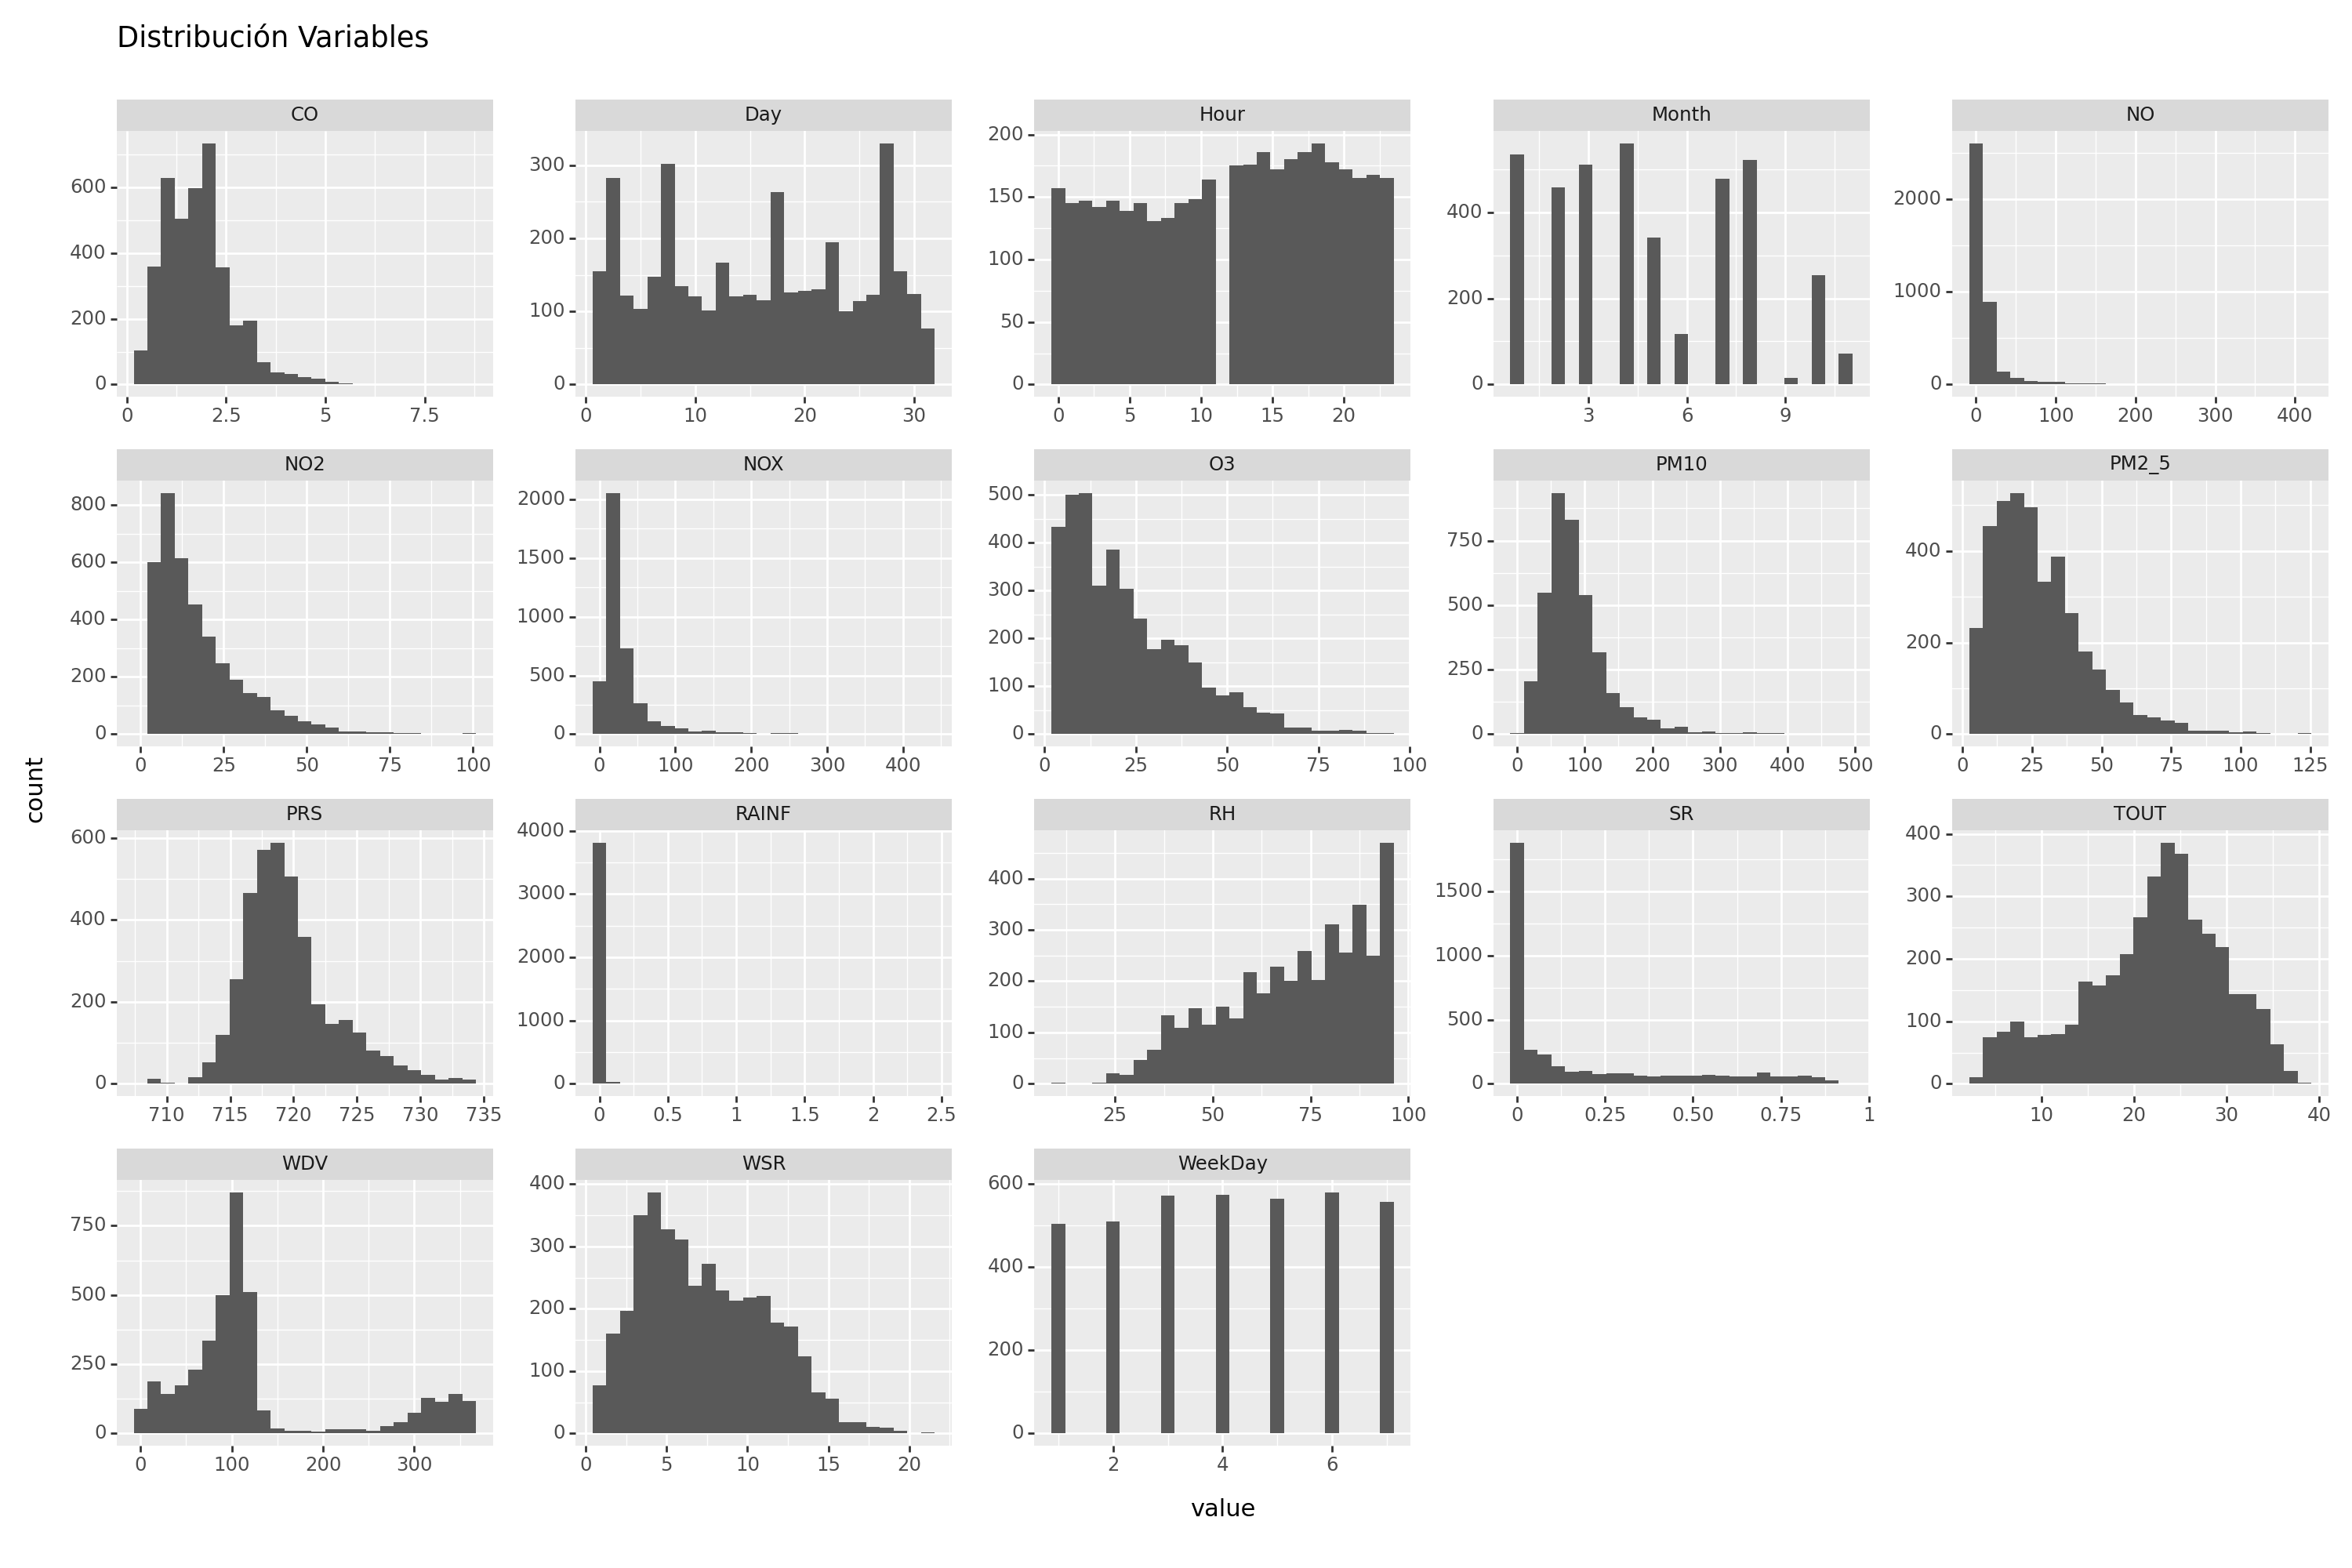

<Figure Size: (1500 x 1000)>

In [ ]:
#**************************************** Declaración de funciones
def statplot(dataframe,output_vars,scale="normal"):
    '''
    Descripción:
      Función encargada de realizar un gráfico de histograma sobre un conjunto de variables
    Inputs:
      * dataframe: dataframe con las variables independientes
      * output_vars: nombres de las variables de salida del array. Se eliminarán para los plots
      * scale: Si se quiere una escala normal (normal), o logaritmica (log)
    Return:
      ggp_hist: Objeto plotnine de histograma

    '''
    #*************Se toman las columnas de las variables independientes
    input_cols=dataframe.columns #Se toman todas las columnas

    #Se toman los datos de las columnas independientes, y aprovechando que no son tantos datos se convierten a un df de pandas
    input_df=dataframe.select(input_cols).toPandas()
    if scale=="log": #Se valida si la impresión es en escala logaritmica
       input_df=np.log(input_df + 1)

    input_df_hist=input_df.melt() #Se almacena un dataframe con la información numérica

    #Se realizan gráficas estadísticas sobre las variables

   #************* boxplots

    fig,axs=plt.subplots(3,6,figsize=(15,5))
    var_count=0
    for i in range(3):
        for j in range(6):
            axs[i,j].boxplot(input_df.iloc[:,var_count])
            axs[i,j].set_xticklabels([input_df.columns[var_count]])
            axs[i,j].set_ylabel(f"Unidades - {input_df.columns[var_count]}")
            var_count=var_count+1
    plt.subplots_adjust(wspace = 0.7,hspace=0.7)
    plt.suptitle("Boxplot Variables",fontsize=20)

    #************* Histogramas
    ggp_hist=(ggplot(input_df_hist,aes(x="value"))) + geom_histogram(bins=25) + facet_wrap('~variable', scales = 'free') + labs(title="Distribución Variables",size=20)  + theme(subplots_adjust={'hspace': 0.7, 'wspace': 0.7},figure_size=(15,10))




    return ggp_hist



#************************************************************************************************
#************* Histogramas

#Para los histogramas se selecciona el conjunto de variables independientes del estudio
output_vars=["O3","PM2_5"]
hist_vars=statplot(data_set,output_vars)
hist_vars





/usr/local/lib/python3.10/dist-packages/plotnine/themes/themeable.py:1902: FutureWarning:

You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.



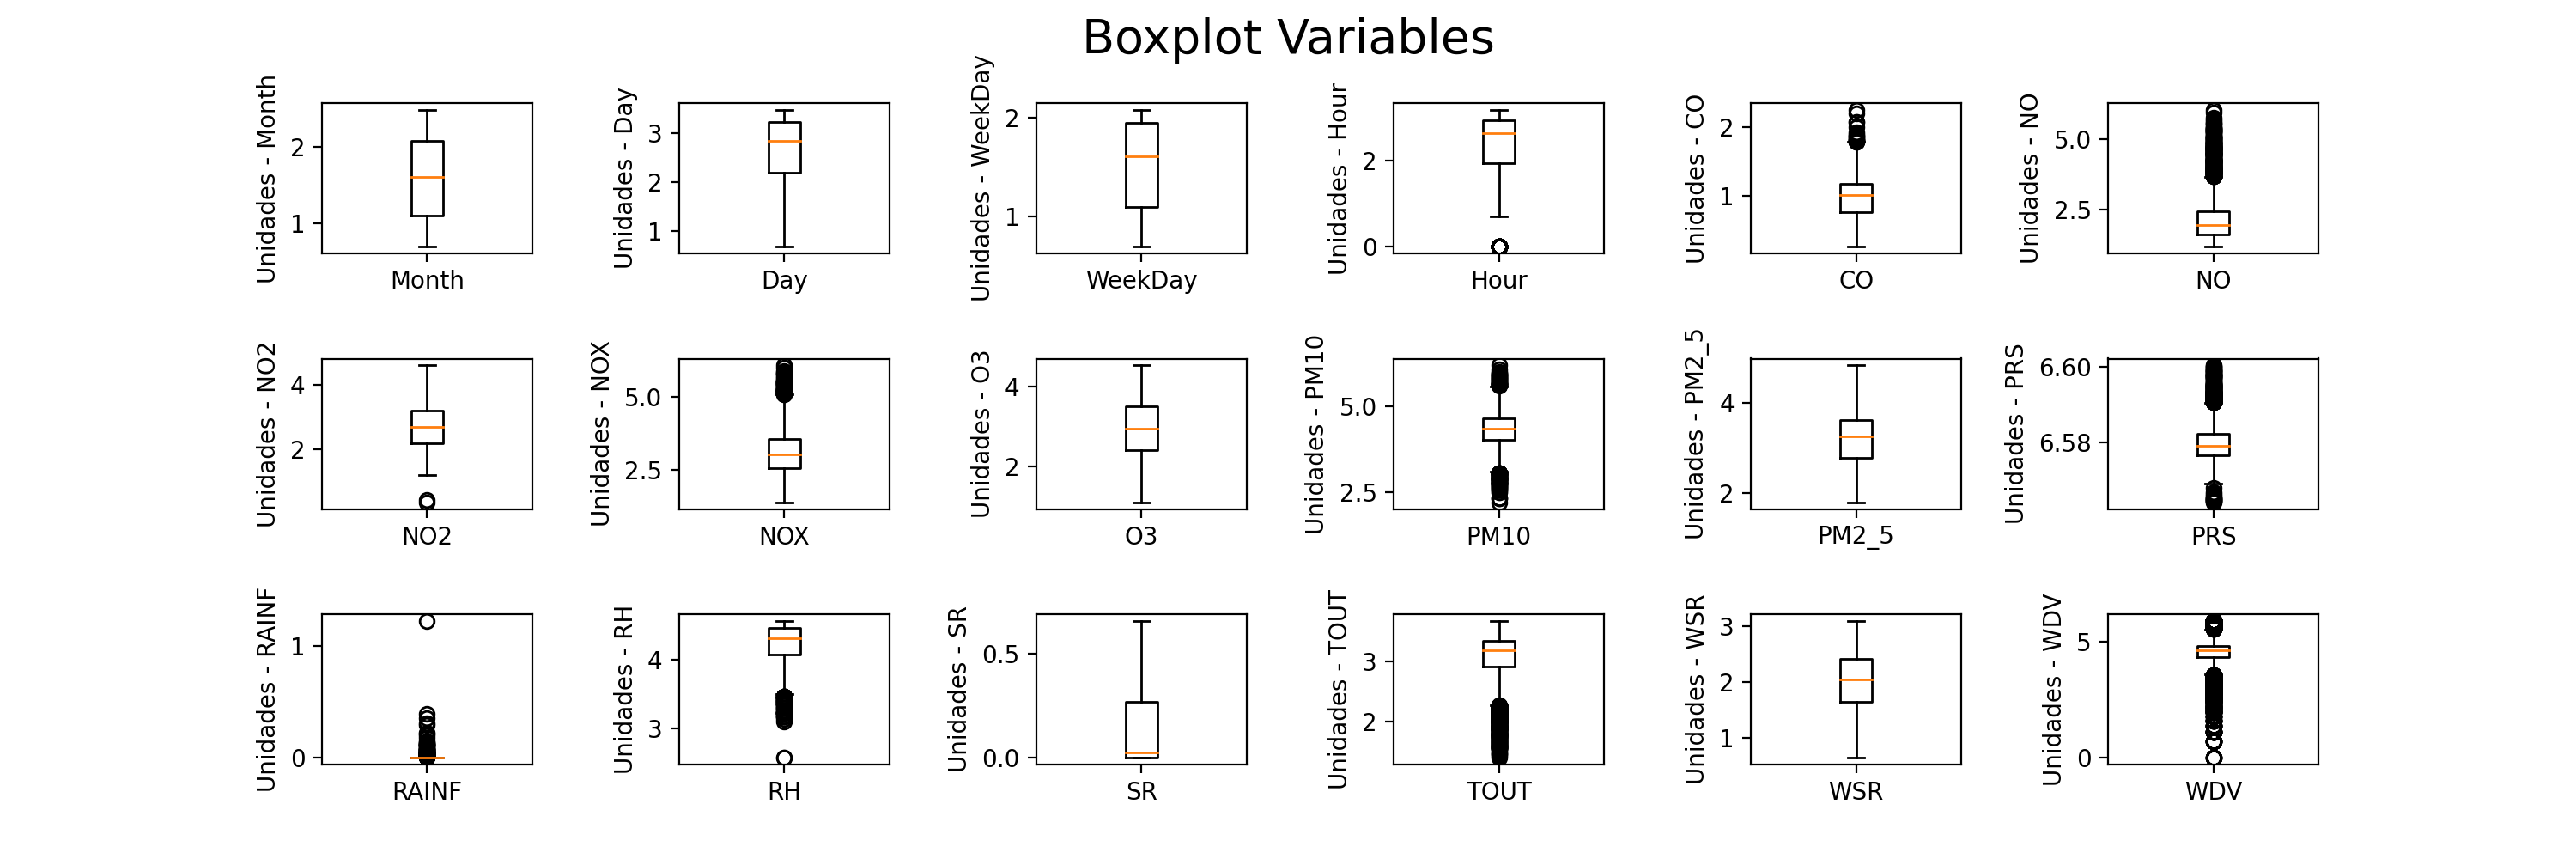

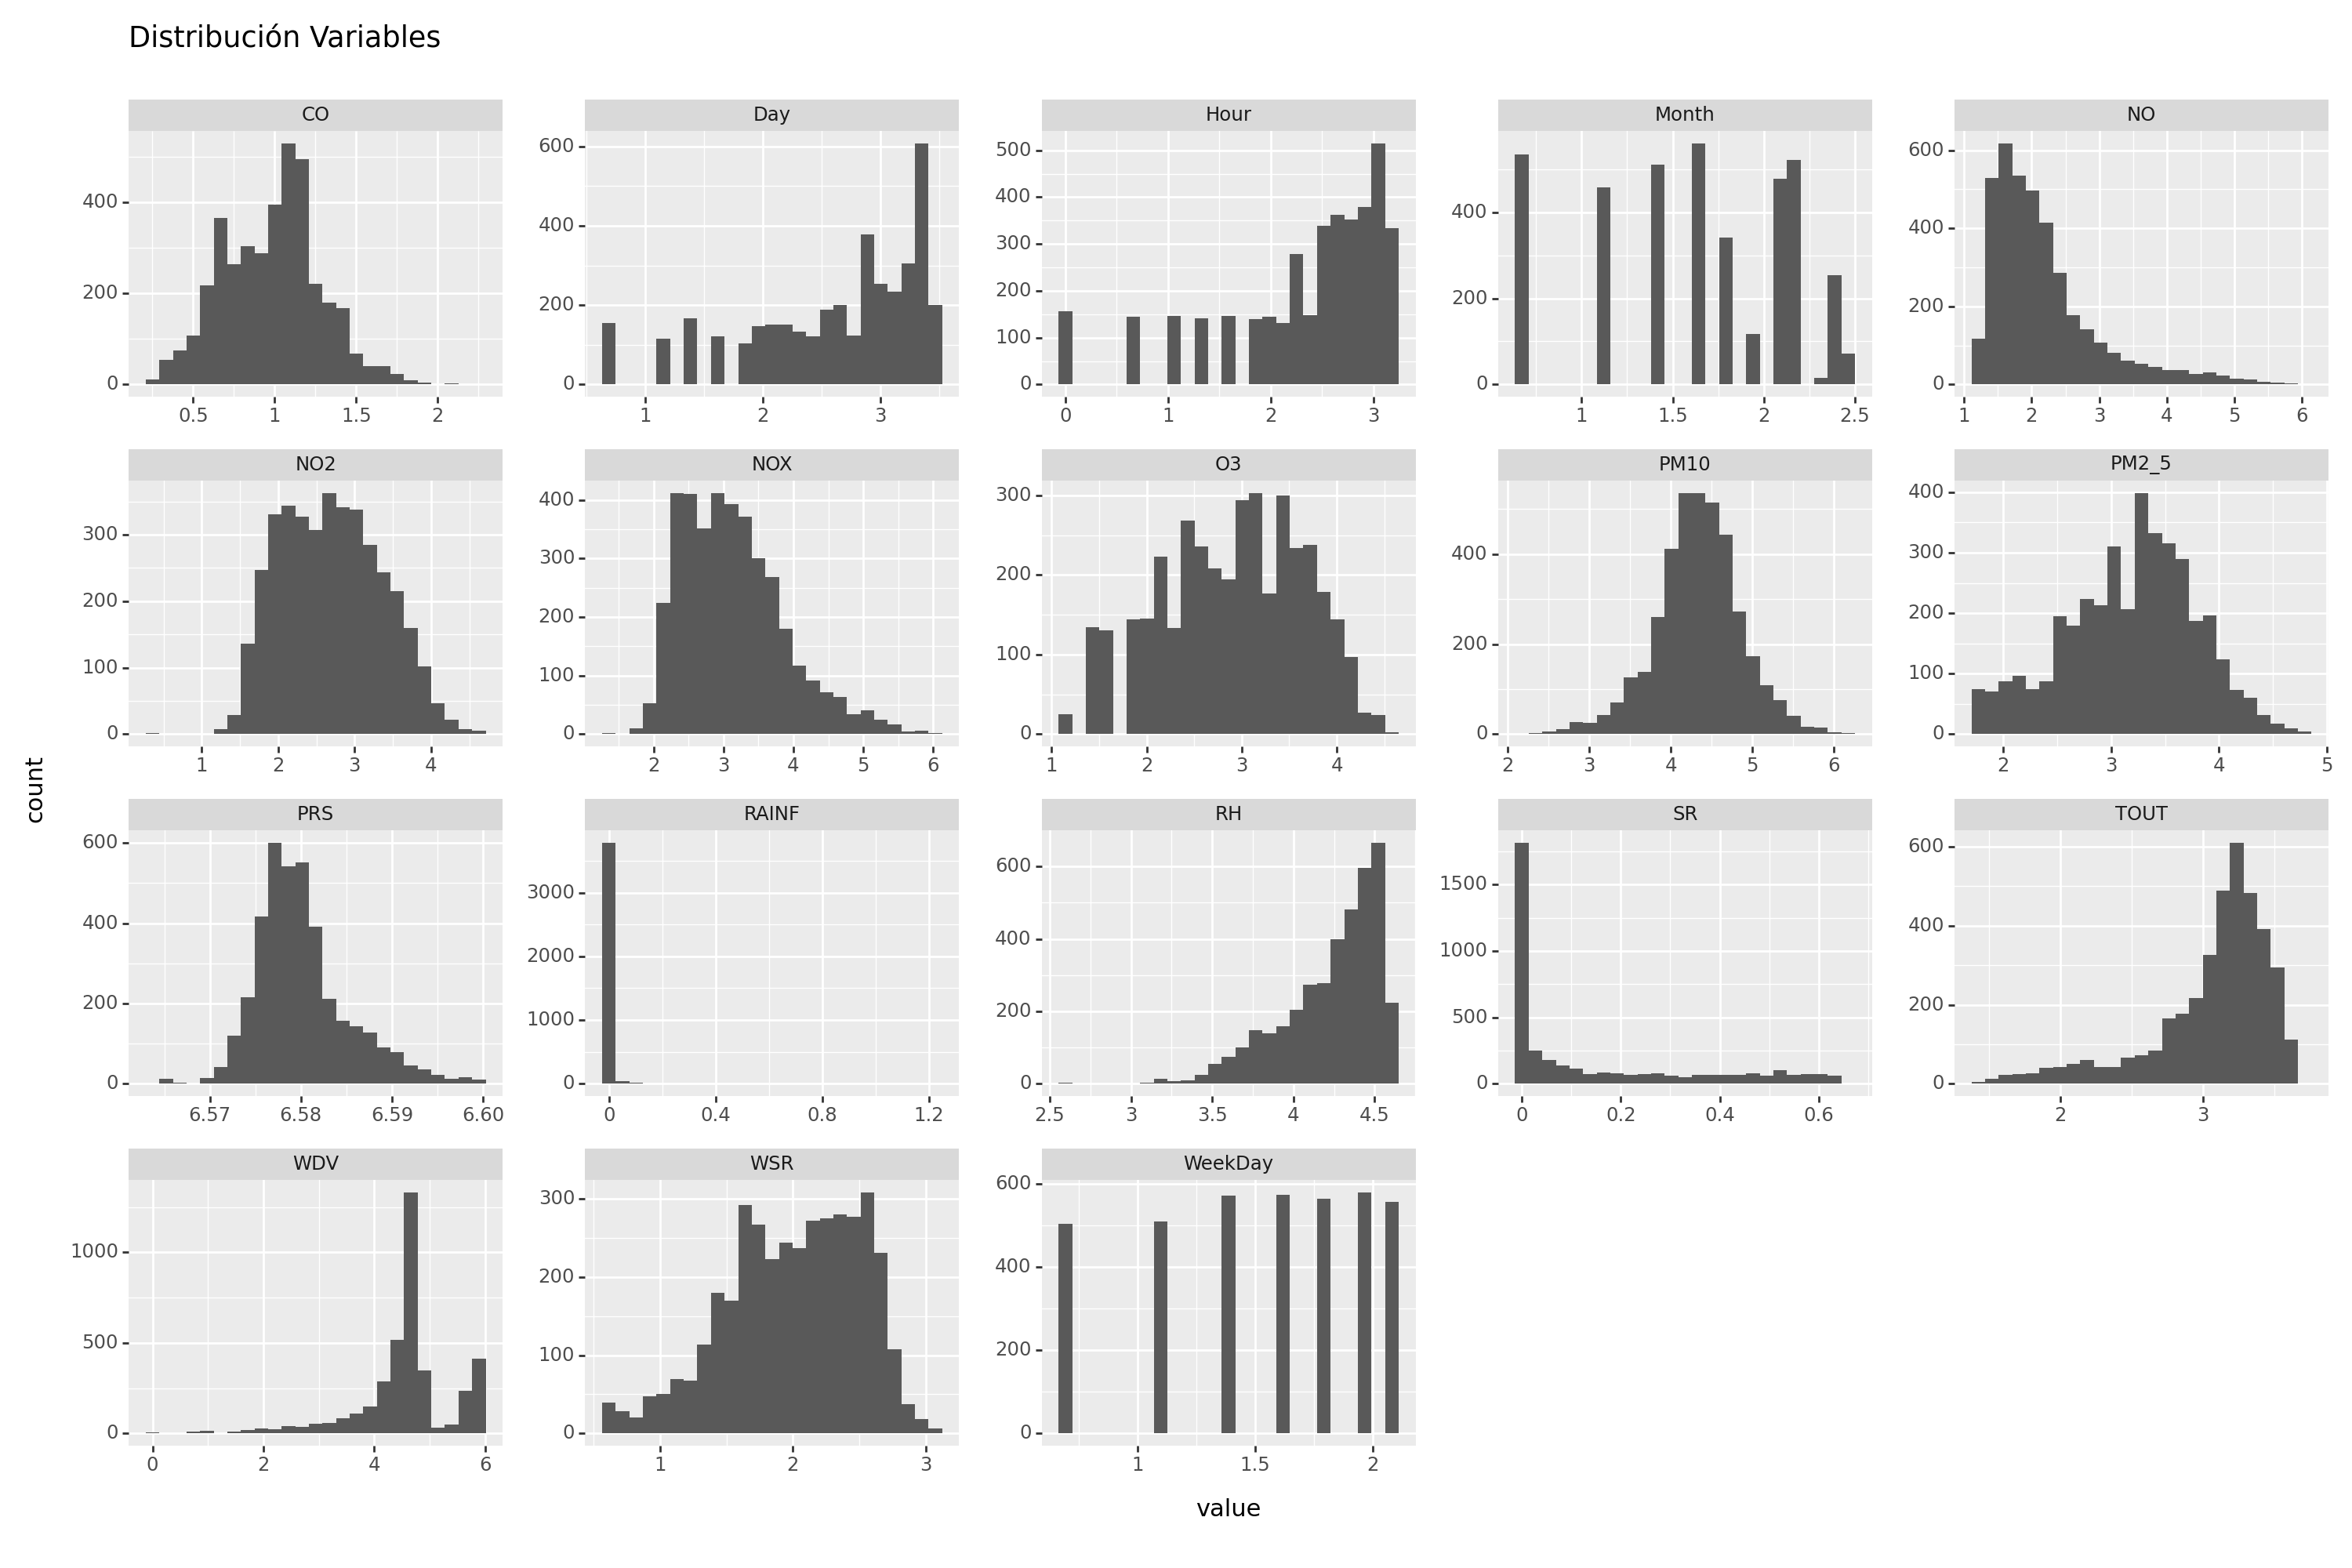

<Figure Size: (1500 x 1000)>

In [ ]:
#******************** Verificación de resultados logarítmicos por convergencia del modelo
hist_log_vars=statplot(data_set,output_vars,"log")
hist_log_vars


## Estudio de correlación

Se genera un mapa de calor, un dataframe con la información de correlación entre las variables, y un diagrama de dispersión para validar la relación entre las variables de estudio y las variables independientes.

##Conclusioes O3

* Se encuentra que las variables que pueden causar aumentos en el contenido de O3 son:  SR, TOUT, WSR, Hour, Month, Day, WeekDay

* Las variables que pueden causar disminuciones en el contenido de O3 son: RAINF, PM10, CO, WDV, PRS, NO, NO2, NOX, RH

* Para la variable O3: Se encuentra que algunas variables weekday, PM10, y RainF presentan correlaciones absolutas menores a 0.05, y pueden llegar a ser poco relaventes.

* Las gráficas horarias y diarias muestran que la concentración promedio de O3 comienza a aumentar hacia el medio día, llegando a un pico hacia las 2 p.m. También, el sábado suele ser el día con mayor concentración promedio.

##Conclusioes PM2.5

* Se encuentra que las variables que pueden causar aumentos en el contenido de PM2.5 son:  PM10, NO2, NOX, NO, CO, Hour, TOUT, RH, RAINF, WeekDay

* Se encuentra que las variables que pueden causar disminución en el contenido de PM2.5 son:  Day, WDV, SR, Month, WSR, PRS

* Para la variable PM2.5: Se encuentra que algunas variables day, weekday, RH,  RainF, SR, WDV presentan correlaciones absolutas menores a 0.05, y pueden llegar a ser poco relaventes.


* Las gráficas horarias y diarias muestran que la concentración promedio de O3 comienza a aumentar hacia la noche, llegando a un pico hacia las 9 p.m. También, el sábado suele ser el día con mayor concentración promedio.

## Conclusiones multicolinealidad

* Se presentan correlaciones mayores a 0.5 entre las variables que pueden resultar en colinealidades. En la sección "Mejorando el modelo" se eliminarán las variables CO, y NOX por presentar posibles multicolinealidades, y tener menor correlación con las variables de salida.

* Variable  Month  y  CO  Presentan posible multicolinealidad, Correlación =  -0.55
* Variable  Month  y  NO2  Presentan posible multicolinealidad, Correlación =  -0.59
* Variable  Month  y  TOUT  Presentan posible multicolinealidad, Correlación =  0.67
* Variable  CO  y  NO  Presentan posible multicolinealidad, Correlación =  0.6
* **Variable  CO  y  NO2  Presentan posible multicolinealidad, Correlación =  0.68**
* **Variable  CO  y  NOX  Presentan posible multicolinealidad, Correlación =  0.7**
* Variable  NO  y  NO2  Presentan posible multicolinealidad, Correlación =  0.56
* **Variable  NO  y  NOX  Presentan posible multicolinealidad, Correlación =  0.95**
* **Variable  NO2  y  NOX  Presentan posible multicolinealidad, Correlación =  0.79**
* Variable  NO2  y  PM10  Presentan posible multicolinealidad, Correlación =  0.55
* Variable  NOX  y  PM10  Presentan posible multicolinealidad, Correlación =  0.56
* Variable  PRS  y  TOUT  Presentan posible multicolinealidad, Correlación =  -0.66
* Variable  RH  y  TOUT  Presentan posible multicolinealidad, Correlación =  -0.55

### Mapa de calor

In [ ]:
#******************** Gráfica y dataframe de correlación
output_vars="Correlation_features" #Vector con nombre de salida
input_cols=data_set.columns #Se toma el nombre de las variables

#******* Se vectorizan las entradas
assembler=VectorAssembler(inputCols=input_cols,outputCol=output_vars)
spark_df_corr=assembler.transform(data_set)

#******* Se calcula la correlación de pearson para las variables, y se genera el dataframe
pearsonCorr = Correlation.corr(spark_df_corr, 'Correlation_features', 'pearson').collect()[0][0]
corr_df_plot=pd.DataFrame(pearsonCorr.toArray(),columns=input_cols,index=input_cols)

#******* Gráfico del mapa de calor para la correlación
fig=px.imshow(corr_df_plot)
fig.show()

#******* Impresión de la matriz de correlación
corr_df_plot

#******* Se identifican las variables que tienen impacto positivo sobre O3
print("**************** Variables que incrementan la presencia de O3 *********************")
print(corr_df_plot[["O3"]].loc[corr_df_plot["O3"]>0].drop(["O3"]).sort_values(by="O3",ascending=False))
print("**************** Variables que disminuyen la presencia de O3 *********************")
print(corr_df_plot[["O3"]].loc[corr_df_plot["O3"]<0].drop(["PM2_5"]).sort_values(by="O3",ascending=False))

#******* Se identifican las variables que tienen impacto positivo sobre PM2.5
print("**************** Variables que incrementan la presencia de PM2_5 *********************")
print(corr_df_plot[["PM2_5"]].loc[corr_df_plot["PM2_5"]>0].drop(["PM2_5"]).sort_values(by="PM2_5",ascending=False))
print("**************** Variables que disminuyen la presencia de PM2_5 *********************")
print(corr_df_plot[["PM2_5"]].loc[corr_df_plot["PM2_5"]<0].drop(["O3"]).sort_values(by="PM2_5",ascending=False))

print("\n **************** Variables con correlación >0.5 posible multicolinealidad *********************")
multicol_df=corr_df_plot.drop(["O3","PM2_5"],axis=1).copy() #Se copia el dataframe sin las variables de salida
multicol_df.drop(["O3","PM2_5"],axis=0,inplace=True) #Se eliminan también de los índices

#Se identifican posibles variables que presenten multicolinealidad
for i in range(multicol_df.shape[0]):
    for j in range(i+1,multicol_df.shape[0]):
        if np.abs(multicol_df.iloc[i,j])>0.5:
           print("Variable ",multicol_df.columns[i] ," y ",multicol_df.columns[j]," Presentan posible multicolinealidad, Correlación = ",np.round(multicol_df.iloc[i,j],2))



**************** Variables que incrementan la presencia de O3 *********************
               O3
SR       0.691927
TOUT     0.527154
WSR      0.466254
Hour     0.228381
Month    0.213890
Day      0.089457
WeekDay  0.015993
**************** Variables que disminuyen la presencia de O3 *********************
             O3
RAINF -0.030142
PM10  -0.046893
CO    -0.196441
WDV   -0.198798
PRS   -0.219732
NO    -0.275251
NO2   -0.302997
NOX   -0.316941
RH    -0.655588
**************** Variables que incrementan la presencia de PM2_5 *********************
            PM2_5
PM10     0.511989
NO2      0.302022
NOX      0.284654
NO       0.232708
CO       0.217616
Hour     0.097884
TOUT     0.083703
RH       0.036154
RAINF    0.030746
WeekDay  0.016755
**************** Variables que disminuyen la presencia de PM2_5 *********************
          PM2_5
Day   -0.013651
WDV   -0.032373
SR    -0.037306
Month -0.057530
WSR   -0.071178
PRS   -0.178029

 **************** Variables con correlación >

In [ ]:
#*************************************Impresión matriz de dispersión
corr_df_plot

,Month,Day,WeekDay,Hour,CO,NO,NO2,NOX,O3,PM10,PM2_5,PRS,RAINF,RH,SR,TOUT,WSR,WDV
Month,1.000000,-0.066819,0.005771,0.005405,-0.548611,-0.313199,-0.591945,-0.453517,0.213890,-0.239885,-0.057530,-0.433587,-0.010824,-0.181146,0.160905,0.673499,0.264641,-0.221022
Day,-0.066819,1.000000,-0.005982,-0.001556,0.101612,0.038179,0.055925,0.049177,0.089457,0.077583,-0.013651,-0.036614,-0.023473,-0.209823,0.062363,0.110851,0.045269,0.028351
WeekDay,0.005771,-0.005982,1.000000,-0.008607,0.033262,-0.036192,-0.022819,-0.035333,0.015993,-0.018170,0.016755,0.067625,0.031300,0.077541,-0.010450,-0.069855,0.025171,-0.049517
Hour,0.005405,-0.001556,-0.008607,1.000000,0.063854,-0.068973,0.065701,-0.027028,0.228381,0.088958,0.097884,-0.047857,0.020795,-0.362518,0.048570,0.218742,0.424072,-0.128215
CO,-0.548611,0.101612,0.033262,0.063854,1.000000,0.597840,0.678066,0.696202,-0.196441,0.396805,0.217616,0.251633,0.010225,0.104443,-0.166540,-0.417004,-0.341591,0.232311
NO,-0.313199,0.038179,-0.036192,-0.068973,0.597840,1.000000,0.562418,0.952031,-0.275251,0.481058,0.232708,0.175222,-0.009182,0.068039,-0.103299,-0.291055,-0.343986,0.259888
NO2,-0.591945,0.055925,-0.022819,0.065701,0.678066,0.562418,1.000000,0.788449,-0.302997,0.550361,0.302022,0.285011,0.009580,0.009099,-0.200736,-0.443810,-0.488231,0.261746
NOX,-0.453517,0.049177,-0.035333,-0.027028,0.696202,0.952031,0.788449,1.000000,-0.316941,0.561353,0.284654,0.236130,-0.003227,0.054647,-0.151194,-0.381639,-0.436568,0.290354
O3,0.213890,0.089457,0.015993,0.228381,-0.196441,-0.275251,-0.302997,-0.316941,1.000000,-0.046893,-0.008811,-0.219732,-0.030142,-0.655588,0.691927,0.527154,0.466254,-0.198798
PM10,-0.239885,0.077583,-0.018170,0.088958,0.396805,0.481058,0.550361,0.561353,-0.046893,1.000000,0.511989,-0.076597,-0.025532,-0.103133,0.055220,0.059941,-0.139638,0.063298


### Diagrama de dispérsión

In [ ]:

#********************************** definición de funciones
def scatter_plot(df,target_var,title):
    '''
    Descripción
      Función encargda de generar scatterplots entre las variables dependientes y una variable de salida

    Inputs:
      * df: dataframe con la data
      * target_var: Variable de salida
      * title: string de texto para el suptitle del scatter plot

    Returns:
      None
    '''
    n_vars=df.shape[1] - 1 #Se toma el número de variables independientes para el gráfico, se resta 1 considerando que hay una variable dependiente
                            #La variable se usa para configurar la rejilla de scatterplots

    if (n_vars %2) ==0: #Se determina el número de colunas y filas del subplot dependiendo de si el tamaño de la matriz es par o impar
        n_cols=n_vars/3
        n_rows=3
    else:
        n_cols=int(n_vars/3) + 1
        n_rows=3

    fig2=make_subplots(rows=n_rows,cols=n_cols)
    dependent_vars=list(df.columns)
    dependent_vars.remove(target_var)

    cont_rows=1
    cont_cols=1
    for column in dependent_vars:
        fig2.add_trace(go.Scatter(x=df[column].values,y=df[target_var].values,mode="markers",name=column),row=cont_rows,col=cont_cols)
        fig2.update_xaxes(title_text=column, row=cont_rows, col=cont_cols,title_standoff=0.1)

        cont_cols=cont_cols+1
        if cont_cols>n_cols:
            cont_cols=1
            cont_rows=cont_rows+1
    fig2.update_layout(title_text=title,title_font=dict(size=30),yaxis_title=target_var,yaxis_title_font=dict(size=30),height=600,width=1200)
    fig2.show()
#***********************************************************************

In [ ]:
#Para no saturar la imagen se generan los scatterplots sobre un 25% de los datos
pandas_data=(data_set.sample(0.25)).toPandas()
#Diagrama de dispersión sobre variable O3
scatter_plot(pandas_data,"O3","Diagrama de dispersión variable O3 [Ppb]")

In [ ]:
#Diagrama de dispersión sobre variable PM2.5
scatter_plot(pandas_data,"PM2_5","Diagrama de dispersión variable PM2.5 [g/m^3]")

### Relación entre días y horas

Se generan gráficos promedios de la evolución de la concentración de O3 y PM2_5 durante el día, para evaluar si se genera más durante algunos días de la semana, o en alguna hora puntual.

Se encuentra una mayor concentración de O3 durante horas del medio día, y durante los días sábado, y de PM2.5 en horas de la noche sobre el día sábado.

In [ ]:
data_set.createOrReplaceTempView("data") #Se crea la data para consultas

#*************************** Query horario

#Query de concentraciones promedio
query=""" SELECT Hour,AVG(O3) AS prom_O3 ,AVG(PM2_5)  AS prom_PM2_5 FROM data GROUP BY Hour ORDER BY Hour """
hourly_data=spark.sql(query)
print("\n **************************** Evoluciones Horarias **************************** ")

#Conversión a pandas
pandas_hourly_data=hourly_data.toPandas()

#Gráfica
fig=make_subplots(rows=1,cols=2)
fig.add_trace(go.Scatter(x=pandas_hourly_data["Hour"],y=pandas_hourly_data["prom_O3"],name="O3 Horario"),row=1,col=1)
fig.update_xaxes(title_text="Hora del día", row=1, col=1)
fig.update_yaxes(title_text="O3 [PpB]", row=1, col=1)

fig.add_trace(go.Scatter(x=pandas_hourly_data["Hour"],y=pandas_hourly_data["prom_PM2_5"],name="PM2_5 Horario"),row=1,col=2)
fig.update_xaxes(title_text="Hora del día", row=1, col=2)
fig.update_yaxes(title_text="PM2.5 [g/m^3]", row=1, col=2)

fig.update_layout(title="Evolución Horaria",title_font=dict(size=18),height=600,width=800)
fig.show()

#*************************** Query Diario
query=""" SELECT WeekDay,AVG(O3) AS prom_O3 ,AVG(PM2_5)  AS prom_PM2_5 FROM data GROUP BY WeekDay ORDER BY WeekDay """
daily_data=spark.sql(query)


 **************************** Evoluciones Horarias **************************** 


In [ ]:
print("\n **************************** Evoluciones Diarias **************************** ")


#Conversión a pandas
pandas_daily_data=daily_data.toPandas()

#Gráfica
fig2=make_subplots(rows=1,cols=2)
fig2.add_trace(go.Scatter(x=pandas_daily_data["WeekDay"],y=pandas_daily_data["prom_O3"],name="O3 Diario"),row=1,col=1)
fig2.update_xaxes(title_text="Día de la semana", row=1, col=1)
fig2.update_yaxes(title_text="O3 [PpB]", row=1, col=1)

fig2.add_trace(go.Scatter(x=pandas_daily_data["WeekDay"],y=pandas_daily_data["prom_PM2_5"],name="PM2_5 Diario"),row=1,col=2)
fig2.update_xaxes(title_text="Día de la semana", row=1, col=2)
fig2.update_yaxes(title_text="PM2.5 [g/m^3]", row=1, col=2)


fig2.update_layout(title="Evolución Diaria",title_font=dict(size=18),height=600,width=800)
fig2.show()


 **************************** Evoluciones Diarias **************************** 


#Implementación de modelos horarios

##Evaluación modelo inicial

Como primer paso en la aplicación del modelo, se ajusta un modelo inicial al set de datos. Esto permite establecer una métrica base que luego se mejorará con la reducción de variables poco relacionadas con las salidas, y mediante la búsqueda de hiperparámetros

* Se estudia la opción de aplicar un modelo Random Forest Regressor (RFR), y GBT Regressor. Obteniendo los siguientes resultados

* Se valora la elección del modelo mediante la métrica r2

* Para el cálculo de r2 en el set de entrenamiento se usa cross validation

## Predicción de O3
* Modelo RFR presenta métrica r2 de 0.80 para set de entrenamiento y 0.77 para set de prueba.

* Modelo GBT presenta métrica r2 de 0.92 para set de entrenamiento y 0.85 para set de prueba.

* Se elige modelo GBT para predicción de O3 por presentar mejores resultados

## Predicción de PM2.5
* Modelo RFR presenta métrica r2 de 0.41 para set de entrenamiento y 0.33 para set de prueba.

* Modelo GBT presenta métrica r2 de 0.59 para set de entrenamiento y 0.33 para set de prueba.

* Se elige modelo RFR para predicción de PM2.5 principalmente porque se obtiene r2 de prueba similar al de GBT, pero a un costo computacional más bajo

In [ ]:
def scoring_prints(model,data_to_score,target_col,set_type,scale="normal"):
    '''
    Descripción
      Función encargada de imprimir el scoring de un modelo sobre un cojunto de entrenamiento, y un conjunto de prueba
      Se imprime el MSE, RMSE, r2

    Inputs:
      * model: Modelo ajustado sobre set de entrenamiento (MODELO YA AJUSTADO!)
      * data_to_score: conjunto sobre el cual se evaluará el score de la predicción (Entrenamiento, o Prueba)
      * target_col: Nombre de la variable a predecir
      * set_type: Tipo de set sobre el cual se calcula el scoring. Si es de entrenamiento ("train") se realiza un cross validation. En caso contrario, se obtienen los resultados de un RegressionEvaluator
      * scale: Considera posible transformación logaritmica sobre la información para buscar forma de campana en los datos.
               Si scale= "normal", se calculan las métricas de scoring sobre valores predecidos sin ninguna transformación
               Si scale= "log", se usa la predicción y_pred*, calculada a partir de la predicción en escala logarítmica y_pred como y_pred*=exp(y_pred)-1
    Returns
      * None
    '''

    prediction_to_score=model.transform(data_to_score)
    R2_evaluator=RegressionEvaluator(labelCol=target_col,predictionCol="prediction",metricName="r2")

    #**************** Impresión resultados set de entrenamiento
    if set_type!="train": #Caso de set de prueba
        if scale=="normal": #En caso de que no se haya aplicado escala logarítmica se imprimen los resultados puros
            #Se toma el arreglo en numpy y se evalúa índice r2
            pred_array=prediction_to_score.select(target_col,"prediction").toPandas().values
            print (f"\n R-Squared: {np.corrcoef(pred_array[:,0],pred_array[:,1])[0,1]**2}")
        else: #En caso de que haya escala logaritmica se transforman las predicciones para el cálculo de r2
            new_pred=prediction_to_score.alias("new_pred") #Se realiza una copia del dataframe
            new_pred=new_pred.withColumn("prediction",exp(col("prediction"))-1) #Se transforman las predicciones
            new_pred=new_pred.withColumn(target_col,exp(col(target_col)) -1) #Se transforman los valores puros del modelo

            pred_array=new_pred.select(target_col,"prediction").toPandas().values
            print (f"\n R-Squared: {np.corrcoef(pred_array[:,0],pred_array[:,1])[0,1]**2}")

    else:  #Caso de set de entrenamiento
        pipeline = Pipeline(stages=[model]) #Se genera pipeline para cross validation
        cross_validator=CrossValidator(estimator=pipeline,estimatorParamMaps=[{}],numFolds=5,evaluator=R2_evaluator) #Se genera objeto
        cross_validator=cross_validator.fit(data_to_score)
        print("\n Score de Cross Validation Set de entrenamiento ",cross_validator.avgMetrics[0])

def model_initial_fit(data_set,output_cols,train_data_ratio,test_data_ratio,target_col):
    '''
    Descripción
      Función encargada de realizar un fit de un random forest regressor sobre un data_set de entrada, considerando una variable output_col a predecir
      Se imprimen estadísticos de scoring sobre set de entrenamiento y prueba
    Inputs:
      * data_set: Dataframe de spark con la información de variables dependientes e independientes
      * output_cols: Lista de variables dependientes
      * train_data_ratio : Ratio de datos (porción) Data set de entrenamiento
      * test_data_ratio : Ratio de datos (porción) Dat
      * target_col: Variable sobre la cual se hace la predicción
    Returns:
      * train_data: Slice correspondiente a data de entrenamiento
      * test_data: Slice correspondiente a data de prueba
    '''

    #************* Se toman las columnas de entrada
    input_cols=data_set.columns
    for col in output_cols:
        input_cols.remove(col)

    #************* Vector assembling de información de entrada
    assembler=VectorAssembler(inputCols=input_cols,outputCol="Attributes")
    ml_df=assembler.transform(data_set)
    ml_df=ml_df.select("Attributes",target_col)

    #************* Separación de train y test
    train_data,test_data=ml_df.randomSplit([train_data_ratio,test_data_ratio],seed=1)
    print("\n Registros set de entrenamiento: ",train_data.count())
    print("\n Registros set de prueba: ",test_data.count())

    return train_data,test_data

#****************************************************************************************************

#*********************************** Estudio de modelo inicial para variable O3
#************ Se generan los sets de entrenamiento y prueba junto con el ajuste del modelo
train_data_O3,test_data_O3=model_initial_fit(data_set,["O3","PM2_5"],0.8,0.2,"O3")

#************* Fit sobre set de entrenamiento
rfr_model_O3=RandomForestRegressor(featuresCol="Attributes",labelCol="O3") #Se crea el modelo
rfr_model_O3=rfr_model_O3.fit(train_data_O3) #Se ajusta sobre set de entrenamiento

#************ Se calculan scorings del modelo. para set de entrenamiento se usa cross validation
print("\n Resultados con modelo Random Forest Regressor")
scoring_prints(rfr_model_O3,train_data_O3,"O3","train","normal")
scoring_prints(rfr_model_O3,test_data_O3,"O3","test","normal")




 Registros set de entrenamiento:  3066

 Registros set de prueba:  793

 Resultados con modelo Random Forest Regressor

 Score de Cross Validation Set de entrenamiento  0.8023267668616672

 R-Squared: 0.7902883653562958


In [ ]:
#*********************************** Estudio de modelo inicial para variable PM2.5
#************ Se generan los sets de entrenamiento y prueba junto con el ajuste del modelo
train_data_PM25,test_data_PM25=model_initial_fit(data_set,["O3","PM2_5"],0.8,0.2,"PM2_5")

#************* Fit sobre set de entrenamiento
rfr_model_PM25=RandomForestRegressor(featuresCol="Attributes",labelCol="PM2_5") #Se crea el modelo
rfr_model_PM25=rfr_model_PM25.fit(train_data_PM25) #Se ajusta sobre set de entrenamiento

#************ Se calculan scorings del modelo. para set de entrenamiento se usa cross validation
print("\n Resultados con modelo Random Forest Regressor")
scoring_prints(rfr_model_PM25,train_data_PM25,"PM2_5","train","normal")
scoring_prints(rfr_model_PM25,test_data_PM25,"PM2_5","test","normal")


 Registros set de entrenamiento:  3066

 Registros set de prueba:  793

 Resultados con modelo Random Forest Regressor

 Score de Cross Validation Set de entrenamiento  0.4026959978873458

 R-Squared: 0.34243072791047274


In [ ]:
#*********************************** Estudio de modelo GBT para variable O3
#************ Se generan los sets de entrenamiento y prueba junto con el ajuste del modelo
train_data_O3,test_data_O3=model_initial_fit(data_set,["O3","PM2_5"],0.8,0.2,"O3")

#************* Fit sobre set de entrenamiento
gbt_model_O3=GBTRegressor(featuresCol="Attributes",labelCol="O3") #Se crea el modelo
gbt_model_O3=gbt_model_O3.fit(train_data_O3) #Se ajusta sobre set de entrenamiento

#************ Se calculan scorings del modelo. para set de entrenamiento se usa cross validation
print("\n Resultados con modelo GBT")
scoring_prints(gbt_model_O3,train_data_O3,"O3","train","normal")
scoring_prints(gbt_model_O3,test_data_O3,"O3","test","normal")



 Registros set de entrenamiento:  3066

 Registros set de prueba:  793

 Resultados con modelo GBT

 Score de Cross Validation Set de entrenamiento  0.9190582678081046

 R-Squared: 0.850602852258085


In [ ]:
#*********************************** Estudio de modelo GBT para variable PM2.5
#************ Se generan los sets de entrenamiento y prueba junto con el ajuste del modelo
train_data_PM25,test_data_PM25=model_initial_fit(data_set,["O3","PM2_5"],0.8,0.2,"PM2_5")

#************* Fit sobre set de entrenamiento
gbt_model_PM25=GBTRegressor(featuresCol="Attributes",labelCol="PM2_5") #Se crea el modelo
gbt_model_PM25=gbt_model_PM25.fit(train_data_PM25) #Se ajusta sobre set de entrenamiento

#************ Se calculan scorings del modelo. para set de entrenamiento se usa cross validation
print("\n Resultados con modelo Random Forest Regressor")
scoring_prints(gbt_model_PM25,train_data_PM25,"PM2_5","train","normal")
scoring_prints(gbt_model_PM25,test_data_PM25,"PM2_5","test","normal")



 Registros set de entrenamiento:  3066

 Registros set de prueba:  793

 Resultados con modelo Random Forest Regressor

 Score de Cross Validation Set de entrenamiento  0.5845537118864418

 R-Squared: 0.32905325087594284


## Mejorando el modelo

Se plantea la siguiente estrategia para mejorar el r2 del modelo:
1. Eliminar Outliers

2. Eliminar variables con multicolinealidad significativa. De las posibles multicolinealidades analizadas se decide eliminar las variables CO y NOX, puesto que presentaban las menores correlaciones con las variables de salida.

3. Ajustar escalas a logarítmicas para dar más forma de campana a las variables

4. Eliminar características poco relavantes por correlación con lla variable de salida.

5. Ejecutar Grid Search para la búsqueda hiperparámetros adecuadas en cada modelo, encontrando un best_model.


In [ ]:
new_data_set=data_set.alias("new_data_set") #Copia del dataset original

#**************************** 1) Removiendo outliers
for column in new_data_set.columns:
    quantiles=new_data_set.approxQuantile(column,[0.25,0.75],0)
    IQR=quantiles[1]-quantiles[0]
    new_data_set=new_data_set.filter((col(column) >= quantiles[0] - 1.5*IQR) & (col(column) <= quantiles[1] + 1.5*IQR))

In [ ]:
#**************************** 2) Se aplica transformación logarítmica sobre set de datos
for column in new_data_set.columns:
    new_data_set=new_data_set.withColumn(column,log(col(column) +1))
new_data_set.show(truncate=10)

#**************************** 3) Se eliminan las variables con multicolinealidad
new_data=new_data_set.drop("CO")
new_data=new_data_set.drop("NOX")


+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----+----------+----------+----------+----------+----------+
|     Month|       Day|   WeekDay|      Hour|        CO|        NO|       NO2|       NOX|        O3|      PM10|     PM2_5|       PRS|RAINF|        RH|        SR|      TOUT|       WSR|       WDV|
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----+----------+----------+----------+----------+----------+
|0.69314...|2.56494...|1.09861...|2.70805...|1.34547...|2.26176...|3.19867...|3.49953...|3.98898...|4.78749...|3.95124...|6.58368...|  0.0|4.07753...|0.39406...|3.02188...|2.47653...|4.63472...|
|0.69314...|2.56494...|1.09861...|2.77258...|1.30562...|2.05412...|2.87919...|3.20274...|3.85014...|4.62497...|3.78418...|6.58368...|  0.0|4.04305...|0.31261...|3.02965...|2.45100...|4.63472...|
|0.69314...|2.56494...|1.

In [ ]:
def relvant_vars(corr_df,target_col,threshold):
    '''
    Descripción
      Función encargada de descargar las variables menos correlacionadas con una variable dependiente target_col

    Inputs
      * corr_df: DataFrame que almacena la matriz de correlaciones
      * target_col: Columna con variable a predecir
      * threshold: Valor mínimo de correlación a considerar

    Return
      * relev_vars: Variables que se mantienen por encima del threshold mínimo de correlación
    '''
    relev_vars=list(corr_df[target_col].loc[corr_df[target_col].abs() > threshold].index)
    return relev_vars

def gridsearch(model,train_data,param_grid,target_col):
    '''
    Descripción
      Función encargada de realizar un grid search meadiante cross validation para determinar el mejor grupo de hiperparámetros para un modelo

    Inputs
      * model: Modelo estimador sobre el cual se seleccionarán los hiperparámetros
      * train_data: Data de entrenamiento
      * param_grid: Grid de búsqueda para hiperparámetros
      * target_col: Variable objetivo a predecir

    Return
      * best_model: Mejor modelo obtenido del cross evaluation
    '''
    R2_evaluator=RegressionEvaluator(labelCol=target_col,predictionCol="prediction",metricName="r2")
    cross_validator = CrossValidator(estimator=model,
                                estimatorParamMaps=param_grid,
                                evaluator=R2_evaluator,
                                numFolds=5)

    cross_validator=cross_validator.fit(train_data)
    best_model=cross_validator.bestModel
    return best_model

#************************************************************************************************
#****************************************** Ejercicio con variables reduciadas para O3

#******** 3) Selección de variables relevantes según correlación
relev_vars_O3=relvant_vars(corr_df_plot.drop(["CO","NOX"],axis=0).drop(["CO","NOX"],axis=1),"O3",0.05)
data_03_reduced=new_data_set.select(relev_vars_O3)
train_data_O3_reduced,test_data_O3_reduced=model_initial_fit(data_03_reduced,["O3"],0.8,0.2,"O3")

#******** 4) Ajuste de hiperparámetros para el modelo
gbt_model_O3=GBTRegressor(featuresCol="Attributes",labelCol="O3") #Se crea el modelo

#Se crea la malla de búsqueda para los hiperparámetros
param_grid = ParamGridBuilder() \
    .addGrid(gbt_model_O3.maxDepth, [1,3,5,7,9,11,13,15,17,19]) \
    .addGrid(gbt_model_O3.maxBins , [15,30,50,70,80,90,100,125]) \
    .build()
best_model_O3=gridsearch(gbt_model_O3,train_data_O3_reduced,param_grid,"O3")

print("Mejor valor parámetro maxDepth: ",best_model_O3.getMaxDepth())
print("Mejor valor parámetro maxBins: ",best_model_O3.getMaxBins())



 Registros set de entrenamiento:  1834

 Registros set de prueba:  442
Mejor valor parámetro maxDepth:  5
Mejor valor parámetro maxBins:  50


In [ ]:
#********************* Evaluación de scoring para variable O3 con el mejor modelo obtenido del cross validation

#************ Se calculan scorings del modelo. para set de entrenamiento se usa cross validation
print("\n Resultados con modelo GBT Regressor mejorado")
scoring_prints(best_model_O3,train_data_O3_reduced,"O3","train","log")
scoring_prints(best_model_O3,test_data_O3_reduced,"O3","test","log")

print("Muestra de las predicciones \n")
predictions=best_model_O3.transform(test_data_O3_reduced).show() #Muestra de las predicciones del mejor modelo sobre set de prueba


 Resultados con modelo GBT Regressor mejorado

 Score de Cross Validation Set de entrenamiento  0.9231959580109415

 R-Squared: 0.809001432926162
Muestra de las predicciones 

+--------------------+------------------+------------------+
|          Attributes|                O3|        prediction|
+--------------------+------------------+------------------+
|[0.69314718055994...|2.8903717578961645| 2.916969870589662|
|[0.69314718055994...| 3.091042453358316|3.0547391017258336|
|[0.69314718055994...| 4.007333185232471| 3.934642151251527|
|[0.69314718055994...|  4.02535169073515|3.9803825416998637|
|[0.69314718055994...| 3.784189633918261|  3.52130931920873|
|[0.69314718055994...|3.1354942159291497|3.2272484711549687|
|[0.69314718055994...|2.9444389791664403|  2.96934920664716|
|[0.69314718055994...|3.4657359027997265|3.5877324682394534|
|[0.69314718055994...| 3.295836866004329|3.2684632054924276|
|[0.69314718055994...| 2.302585092994046| 2.947284918719341|
|[0.69314718055994...| 4.06044

In [ ]:
#****************************************** Ejercicio con variables reduciadas para PM2_5

#******** 3) Selección de variables relevantes según correlación
relev_vars_PM25=relvant_vars(corr_df_plot.drop(["CO","NOX"],axis=0).drop(["CO","NOX"],axis=1),"PM2_5",0.05)
data_PM25_reduced=data_set.select(relev_vars_PM25)
train_data_PM25_reduced,test_data_PM25_reduced=model_initial_fit(data_set,["PM2_5","O3"],0.8,0.2,"PM2_5")

#******** 4) Ajuste de hiperparámetros para el modelo
rfr_model_PM25=RandomForestRegressor(featuresCol="Attributes",labelCol="PM2_5") #Se crea el modelo

#Se crea la malla de búsqueda para los hiperparámetros
param_grid = ParamGridBuilder() \
    .addGrid(rfr_model_PM25.maxDepth, [5,10,15,20,25,30]) \
    .addGrid(rfr_model_PM25.numTrees, [5,7,9,11,15,20,30,35,50]) \
    .build()
best_model_PM25=gridsearch(rfr_model_PM25,train_data_PM25_reduced,param_grid,"PM2_5")

print("Mejor valor parámetro maxDepth: ",best_model_PM25.getMaxDepth())
print("Mejor valor parámetro numTrees: ",best_model_PM25.getNumTrees)




 Registros set de entrenamiento:  3066

 Registros set de prueba:  793
Mejor valor parámetro maxDepth:  15
Mejor valor parámetro numTrees:  50


In [ ]:
#********************* Evaluación de scoring para variable PM2.5 con el mejor modelo obtenido del cross validation

#************ Se calculan scorings del modelo. para set de entrenamiento se usa cross validation
print("\n Resultados con modelo Random Forest Regressor mejorado")
scoring_prints(best_model_PM25,train_data_PM25_reduced,"PM2_5","train","normal")
scoring_prints(best_model_PM25,test_data_PM25_reduced,"PM2_5","test","normal")

print("Muestra de las predicciones \n")
predictions=best_model_PM25.transform(test_data_PM25_reduced).show() #Muestra de las predicciones del mejor modelo sobre set de prueba


 Resultados con modelo Random Forest Regressor mejorado

 Score de Cross Validation Set de entrenamiento  0.875318952870693

 R-Squared: 0.38872513109702156
Muestra de las predicciones 

+--------------------+-----+------------------+
|          Attributes|PM2_5|        prediction|
+--------------------+-----+------------------+
|[1.0,1.0,5.0,8.0,...|    8| 8.478722222222222|
|[1.0,1.0,5.0,19.0...|   33|25.229010467344832|
|[1.0,1.0,5.0,20.0...|   10| 24.51633753501401|
|[1.0,1.0,5.0,22.0...|   14|12.291521863799284|
|[1.0,2.0,6.0,0.0,...|   12|10.829904761904764|
|[1.0,2.0,6.0,18.0...|   29|27.748599439775912|
|[1.0,2.0,6.0,21.0...|   40|22.332882352941173|
|[1.0,2.0,6.0,22.0...|   23| 18.85928314659197|
|[1.0,3.0,7.0,10.0...|   35| 20.82311491108071|
|[1.0,3.0,7.0,12.0...|   39|  18.6521869232189|
|[1.0,3.0,7.0,20.0...|  119|             83.82|
|[1.0,4.0,1.0,16.0...|   31| 13.16780341880342|
|[1.0,4.0,1.0,20.0...|   17|26.169965517241376|
|[1.0,5.0,2.0,6.0,...|   17| 19.569722689075

#Implementación de modelos diarios

Siguiendo la recomendación del material, se generan tres tablas de datos, con los valores máximos, mínimos

##Creando los dataframes

In [ ]:
#******** 3) Selección de variables relevantes según correlación
relev_vars_O3=relvant_vars(corr_df_plot.drop(["CO","NOX"],axis=0).drop(["CO","NOX"],axis=1),"O3",0.05)
data_03_reduced=new_data_set.select(relev_vars_O3)
train_data_O3_reduced,test_data_O3_reduced=model_initial_fit(data_03_reduced,["O3"],0.8,0.2,"O3")

#******** 3) Selección de variables relevantes según correlación
relev_vars_PM25=relvant_vars(corr_df_plot.drop(["CO","NOX"],axis=0).drop(["CO","NOX"],axis=1),"PM2_5",0.05)
data_PM25_reduced=data_set.select(relev_vars_PM25)
train_data_PM25_reduced,test_data_PM25_reduced=model_initial_fit(data_set,["PM2_5","O3"],0.8,0.2,"PM2_5")


 Registros set de entrenamiento:  1834

 Registros set de prueba:  442

 Registros set de entrenamiento:  3066

 Registros set de prueba:  793


In [ ]:
def rename_cols(df,agg_text):
    '''
    Descripción:
      Función que se encarga de limpiar los encabezados de un dataframe de entrada, del tipo agg(x), dejando solo x
    Inputs:
      * df: Dataframe con la información
      * agg_text: texto considerado en agg para limpiar. Por ejemplo min(, avg( ....
    Return:
      * df: Dataframe con columnas renombradas

    '''
    columns=df.columns
    new_columns=[]
    for column in columns:
        text=column.replace(agg_text, "").replace(")", "")
        new_columns.append(text)

    for old_col,new_col in zip(columns,new_columns):
        df=df.withColumnRenamed(old_col,new_col)

    return df

def group_dfs(df):
    '''
    Descripción:
      Función encargada de agrupar un dataframe de entrada por fecha, calculando como salidas dfs con valores máximos, promedio y mínimos
    Inputs:
      * df: DataFrame con data
    Returns:
      * max_df: Datos agrupados por fecha, y con cálculo de valores máximos sobre los datos horarios del día
      * mean_df: Datos agrupados por fecha, y con cálculo de valores promedio sobre los datos horarios del día
      * min_df: Datos agrupados por fecha, y con cálculo de valores mínimos sobre los datos horarios del día
    '''

    #************* Toma de columnas
    grouping_variables=["Date"] #Variables que se usan para agrupar, Day, y Month

    indep_vars=df.columns #Variables independientes
    indep_vars.remove("Date") #Se eliminan variable de agrupamiento

    #*************** Agrupar datos máximos
    max_df=df.groupBy(*grouping_variables).agg({column: "max" for column in indep_vars}).orderBy(["max(Month)","max(Day)"])

    #*************** Query para agrupar datos Promedio
    mean_df=df.groupBy(*grouping_variables).agg({column: "avg" for column in indep_vars}).orderBy(["avg(Month)","avg(Day)"])

    #*************** Query para agrupar datos minimos
    min_df=df.groupBy(*grouping_variables).agg({column: "min" for column in indep_vars}).orderBy(["min(Month)","min(Day)"])

    return min_df, mean_df, max_df

#*******************************************************************************************************

#**************** 1. Se parte del data set original, y se eliminan las variables con poca correlación con la salida, y que presentaron multicolinealidad

#******* Se incluye nuevamente la variable de fehca para hacer el agrupamiento
min_data,avg_data,max_data=group_dfs(data_set.join(data_raw.select("Date","Month","Day"), on=["Month","Day"],how="inner"))

#******* Se renombran las columnas de los dataframes para poder aplicar la selección de columnas que ya se trabajó
min_data=rename_cols(min_data,"min(")
avg_data=rename_cols(avg_data,"avg(")
max_data=rename_cols(max_data,"max(")

#******* Se elgien las columnas relevantes para cada variable de salida O3, y se eliminan variables con multicolinealidad
min_data_O3=min_data.select(relev_vars_O3)
min_data_O3=min_data_O3.drop("CO","NOX","PM2_5")

avg_data_O3=avg_data.select(relev_vars_O3)
avg_data_O3=avg_data_O3.drop("CO","NOX","PM2_5")

max_data_O3=max_data.select(relev_vars_O3)
max_data_O3=max_data_O3.drop("CO","NOX","PM2_5")


#******* Se elgien las columnas relevantes para cada variable de salida PM2_5, y se eliminan variables con multicolinealidad
min_data_PM2_5=min_data.select(relev_vars_PM25)
min_data_PM2_5=min_data_PM2_5.drop("CO","NOX")

avg_data_PM2_5=avg_data.select(relev_vars_PM25)
avg_data_PM2_5=avg_data_PM2_5.drop("CO","NOX")


max_data_PM2_5=max_data.select(relev_vars_PM25)
max_data_PM2_5=max_data_PM2_5.drop("CO","NOX")



In [ ]:
#**************** Muestras de resultados
print("******* Tabla con datos mínimos *********")
min_data.show(5,truncate=8)
print("******* Tabla con datos promedio *********")
avg_data.show(5,truncate=8)
print("******* Tabla con datos máximos *********")
max_data.show(5,truncate=8)


******* Tabla con datos mínimos *********
+--------+-------+---+-----+-----+-----+----+-----+---+---+----+----+---+---+---+-----+----+----+---+
|    Date|WeekDay|WSR|  PRS|RAINF|Month| NO2| TOUT| NO|Day| NOX|  CO| RH|WDV| O3|PM2_5|Hour|PM10| SR|
+--------+-------+---+-----+-----+-----+----+-----+---+---+----+----+---+---+---+-----+----+----+---+
|01-en...|      5|2.9|720.6|  0.0|    1| 8.2| 3.79|5.3|  1|14.0|2.21| 93|  2|  5|    6|   1|  15|0.0|
|02-en...|      6|1.8|717.9|  0.0|    1| 8.1| 4.41|3.8|  2|12.3|2.19| 87|  1|  4|    5|   0|   8|0.0|
|03-en...|      7|1.1|718.1|  0.0|    1| 9.7| 5.84|3.6|  3|13.3|2.22| 73|  6|  4|    6|   2|  16|0.0|
|04-en...|      1|3.4|728.7|  0.0|    1|10.5|10.39|4.6|  4|16.7| 2.3| 46| 14|  6|    5|  13|  35|0.0|
|05-en...|      2|3.3|729.8|  0.0|    1|10.3| 6.87|3.9|  5|14.9|2.18| 62| 51|  7|    7|   0|  24|0.0|
+--------+-------+---+-----+-----+-----+----+-----+---+---+----+----+---+---+---+-----+----+----+---+
only showing top 5 rows

******* Tabla c

##Ajustando nuevamente modelos

## Modelos Variable O3

In [ ]:
#************************************************* Variable O3 - Mínimos
train_data_O3_min,test_data_O3_min=model_initial_fit(min_data_O3,["O3"],0.8,0.2,"O3")

#************* Fit sobre set de entrenamiento - GBT
gbt_model_O3_min=GBTRegressor(featuresCol="Attributes",labelCol="O3") #Se crea el modelo
gbt_model_O3_min=gbt_model_O3_min.fit(train_data_O3_min) #Se ajusta sobre set de entrenamiento

#************* Impresión
scoring_prints(gbt_model_O3_min,train_data_O3_min,"O3","train","normal")
scoring_prints(gbt_model_O3_min,test_data_O3_min,"O3","test","normal")



 Registros set de entrenamiento:  187

 Registros set de prueba:  43

 Score de Cross Validation Set de entrenamiento  0.9864255337166632

 R-Squared: 0.07571060707685069


In [ ]:
#********************* Ajustando y creando el modelo
train_data_O3_min,test_data_O3_min=model_initial_fit(min_data_O3,["O3"],0.8,0.2,"O3") #Separación set de entrenamiento y prueba
gbt_model_O3_min=GBTRegressor(featuresCol="Attributes",labelCol="O3") #Se crea el modelo
gbt_model_O3_min=gbt_model_O3_min.fit(train_data_O3_min) #Se ajusta sobre set de entrenamiento
prediction=gbt_model_O3_min.transform(test_data_O3_min) #Predicción del modelo
evaluator = RegressionEvaluator(labelCol="O3", predictionCol="prediction", metricName="r2") #se define el evaluador
R2=evaluator.evaluate(prediction) #evaluación r2
print("R2 - SPARK:",R2)

#********************* Código con pandas
print("\n Cálculos con pandas")
pred_df=prediction.select("O3","prediction").toPandas() #Creando el dataframe en pandas
print(pred_df.head(5)) #Impresión de muestra de resultados
pred_df.corr() #Matriz de correlación



 Registros set de entrenamiento:  187

 Registros set de prueba:  43
R2 - SPARK: -2.206525508707594

 Cálculos con pandas
   O3  prediction
0   7    2.841652
1   4    5.320070
2   4    4.278910
3   6    6.222211
4  10    5.200019


,O3,prediction
O3,1.000000,0.275156
prediction,0.275156,1.000000


In [ ]:
#************************************************* Variable O3 - Medios
train_data_O3_avg,test_data_O3_avg=model_initial_fit(avg_data_O3,["O3"],0.8,0.2,"O3")

#************* Fit sobre set de entrenamiento - GBT
gbt_model_O3_avg=GBTRegressor(featuresCol="Attributes",labelCol="O3") #Se crea el modelo
gbt_model_O3_avg=gbt_model_O3_avg.fit(train_data_O3_avg) #Se ajusta sobre set de entrenamiento

#************* Impresión
scoring_prints(gbt_model_O3_avg,train_data_O3_avg,"O3","train","normal")
scoring_prints(gbt_model_O3_avg,test_data_O3_avg,"O3","test","normal")



 Registros set de entrenamiento:  187

 Registros set de prueba:  43

 Score de Cross Validation Set de entrenamiento  0.9899033456820939

 R-Squared: 0.5212226487191962


In [ ]:
#************************************************ Variable O3 - Máximos
train_data_O3_max,test_data_O3_max=model_initial_fit(max_data_O3,["O3"],0.8,0.2,"O3")


#************* Fit sobre set de entrenamiento - GBT
gbt_model_O3_max=GBTRegressor(featuresCol="Attributes",labelCol="O3") #Se crea el modelo
gbt_model_O3_max=gbt_model_O3_max.fit(train_data_O3_max) #Se ajusta sobre set de entrenamiento

#************* Impresión
scoring_prints(gbt_model_O3_max,train_data_O3_max,"O3","train","normal")
scoring_prints(gbt_model_O3_max,test_data_O3_max,"O3","test","normal")


 Registros set de entrenamiento:  187

 Registros set de prueba:  43

 Score de Cross Validation Set de entrenamiento  0.985344043721269

 R-Squared: 0.3730740724550905


## Modelo variable PM2.5

In [ ]:
#************************************************* Variable PM2.5 - Mínimos
train_data_PM_min,test_data_PM_min=model_initial_fit(min_data_PM2_5,["PM2_5"],0.8,0.2,"PM2_5")

#************* Fit sobre set de entrenamiento - RFR
rfr_model_PM_min=RandomForestRegressor(featuresCol="Attributes",labelCol="PM2_5") #Se crea el modelo
rfr_model_PM_min=rfr_model_PM_min.fit(train_data_PM_min) #Se ajusta sobre set de entrenamiento

#************* Impresión
scoring_prints(rfr_model_PM_min,train_data_PM_min,"PM2_5","train","normal")
scoring_prints(rfr_model_PM_min,test_data_PM_min,"PM2_5","test","normal")


 Registros set de entrenamiento:  187

 Registros set de prueba:  43

 Score de Cross Validation Set de entrenamiento  0.7189968697671459

 R-Squared: 0.15086097977166102


In [ ]:
#************************************************* Variable PM2.5 - Promedio
train_data_PM_avg,test_data_PM_avg=model_initial_fit(avg_data_PM2_5,["PM2_5"],0.8,0.2,"PM2_5")

#************* Fit sobre set de entrenamiento - RFR
rfr_model_PM_avg=RandomForestRegressor(featuresCol="Attributes",labelCol="PM2_5") #Se crea el modelo
rfr_model_PM_avg=rfr_model_PM_avg.fit(train_data_PM_avg) #Se ajusta sobre set de entrenamiento

#************* Impresión
scoring_prints(rfr_model_PM_avg,train_data_PM_avg,"PM2_5","train","normal")
scoring_prints(rfr_model_PM_avg,test_data_PM_avg,"PM2_5","test","normal")


 Registros set de entrenamiento:  187

 Registros set de prueba:  43

 Score de Cross Validation Set de entrenamiento  0.800976264034755

 R-Squared: 0.39131439024249154


In [ ]:
#************************************************* Variable PM2.5 - Max
train_data_PM_max,test_data_PM_max=model_initial_fit(max_data_PM2_5,["PM2_5"],0.8,0.2,"PM2_5")

#************* Fit sobre set de entrenamiento - RFR
rfr_model_PM_max=RandomForestRegressor(featuresCol="Attributes",labelCol="PM2_5") #Se crea el modelo
rfr_model_PM_max=rfr_model_PM_max.fit(train_data_PM_max) #Se ajusta sobre set de entrenamiento

#************* Impresión
scoring_prints(rfr_model_PM_max,train_data_PM_max,"PM2_5","train","normal")
scoring_prints(rfr_model_PM_max,test_data_PM_max,"PM2_5","test","normal")


 Registros set de entrenamiento:  187

 Registros set de prueba:  43

 Score de Cross Validation Set de entrenamiento  0.6717170472992903

 R-Squared: 0.594435972386798


#Conclusiones Finales

Se llevó a cabo la implementación de modelos de regresión sobre las variables de salida O3, y PM2.5. La implementación de estos modelos partió de una condición incial en resolución horaria, donde se manejaron sus hiperparámetros por default con todas las variables, y posteriormente se mejoró el resultado, eliminando del análisis variables poco correlacionadas con las salidas, limpiando outliers y ajustando sus hiperparámetros mediante un grid search en spark.

También se lleva a cabo un análisis para los valores máximos, medios, y mínimos en resolución diaria.

## Conclusiones para variable O3
* Se encontró que las variables Month, Day, Hour, SR, TOUT, y WSR , tienden a aumentar los niveles de O3, mientras que las variables NO, NO2, PRS, RH, WDV tienden a disminuirlo. Las demás variables no consideraron como relevantes por guardar poca relación con la concentración de O3.

* Los resultados del análisis muestran que es posible obtener una buena predicción de los valores de O3 a nivel horario. La calidad de la predicción disminuye cuando se miran las predicciones a nivel diario. Esto puede deberse a la cantidad de datos de entrenamiento, y vale la pena ahondar en el punto.

* Se implementa un modelo GBT Regressor en resolución horaria. El modelo se optimizó para llegar a un valor $r^2$ de 0.92 sobre conjunto de entrenamiento y 0.81 sobre conjunto de prueba. El modelo se ajustó con los hiperparámetros MaxDepth = 5 y MaxBins=50

* Los resultados del modelo muestran que sí existe una relación entre el tráfico y concentración de O3. **Se recomienda el uso del modelo horario para predicción de O3**

## Conclusiones para variable PM2.5

* Se encontró que las variables Hour, NO, NO2, PM10, TOUT , tienden a aumentar los niveles de PM2.5, mientras que las variables Month, PRS, WSR, tienden a disminuirlo. Las demás variables no consideraron como relevantes por guardar poca relación con la concentración de PM2.5.

* Los resultados del análisis muestran que no se logra obtener una buena predicción de los valores de PM2.5 a nivel horario. La calidad de la predicción aumenta cuando se miran las predicciones a nivel diario para las concentraciones máximas y promedio. Esto puede deberse a la naturaleza de las variables, y vale la pena ahondar en el punto.

* A nivel horario se presenta un modelo optimizado Random Forest Regressor con los parámetros MaxDepth=15 y numTrees=50. Se consigue un $r^2$ de de 0.87 sobre set de entrenamiento, y 0.39 sobre set de prueba. Esto es evidencia de posible sobreajuste, y no se recomienda su uso.

* A nivel diario se presenta implementación de un modelo Random Forest Regressor en resolución diaria.

  * Para las concentraciones Promedio de PM2.5 El modelo inicial presentó un valor r2 de 0.8 sobre el set de entrenamiento y 0.39 sobre el set de prueba. Esto es evidencia de posible sobreajuste, y no se recomienda su uso.

   * Para las concentraciones máximas de PM2.5 El modelo inicial presentó un valor r2 de 0.67 sobre el set de entrenamiento y 0.59 sobre el set de prueba.
   
  * Los hiperparámetros del modelo son los tomados por default. Vale la pena considerar una posible optimización sobre el modelo. MaxDepth= 5, NumTrees= 20

* Los resultados que puede existir una relación entre el tráfico y la presencia de PM2.5, pero que no es tan marcada como en el caso del O3. **Se recomienda usar el modelo de regresión para pronosticar el nivel máximo de PM2.5 a nivel diario**.
